In [1]:
import os
import json
import random
import string
from typing import Annotated, TypedDict, List, Sequence, Optional
from langchain_groq import ChatGroq 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import Command
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage,AIMessage,ToolMessage
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, InjectedState, tools_condition
from dotenv import load_dotenv

In [2]:
load_dotenv()
api_key = os.getenv("GROQ_API_KEY")

In [3]:
llm = ChatGroq(model="llama-3.1-8b-instant")

In [5]:
class SupervisorState(MessagesState):
    """
        State for multi-agent system
    """   
    user_input: str
    user_intent: str
    complaint: dict
    missing_info: list
    next: str

# Supervisor Node

def supervisor_node(state:SupervisorState)->SupervisorState:

    if state.get('complaint_in_progress'):
        return Command(goto="Complaint Agent")
 
    system_prompt = """
    You are a supervisor. Classify the user query into one of: inquiry, complaint, retention.

    Rules:
    - If the user mentions cancelling, switching, leaving, or expresses strong frustration about continuing the service, classify as retention.
    - If the user complains but does not express intent to leave, classify as complaint.
    - If the user is asking for info or guidance, classify as inquiry.
    """
    
    response = llm.invoke([
        {"role":"system", "content":system_prompt},
        {"role":"user", "content":state["user_input"]}
        ])
    
    intent=response.content.strip().lower()
    state['user_intent']=intent

    if intent=="inquiry":
        return Command(goto="Inquiry Agent")
    elif intent=="complaint":
        return Command(goto="Complaint Agent")
    elif intent=="retention":
        return Command(goto="Retention Agent")
    else:
        return Command(goto="Fallback")


In [6]:
# Worker nodes

def inquiry_node(state:SupervisorState)->SupervisorState:
    return {'messages':[f"Inquiry Handled: {state['user_input']}"]}

def fallback(state:SupervisorState)->SupervisorState:
    return {'messages':[f"Sorry, I couldn't understand your message"]}

In [7]:
def nlu_node(state:SupervisorState)->SupervisorState:
    """ 
        NLU Extractor agent that extract entities (product, issue_type, and purchase_date) from user input. 
    """
    user_input = state["user_input"]
    current_complaint = state.get('complaint',{})

    system_prompt=f""" You are an entity extractor. 
    Your goal is to extract the latest product, issue_type, and purchase_date 
    from the user's input.
    - product
    - issue_type
    - purchase_date

    Respond ONLY with a valid JSON object in this exact format:
    {{
        "product": string or null,
        "issue_type": string or null,
        "purchase_date": MM/DD/YY or null
    }}
    """
     
    response = llm.invoke([
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_input)
        ])
    
    complaint_data =json.loads(response.content)
    updated_complaint = {k: current_complaint.get(k) or v for k,v in complaint_data.items()}
    missing_data = [k for k,v in updated_complaint.items() if not v]
    state['complaint'] = updated_complaint
    state['missing_info']=missing_data
    
    return state
   
def ask_missing_info(state:SupervisorState)->SupervisorState:
    """" 
        This Agent validate th data from NLU agent and ask missing information from user input.
    """
    complaint_data = state['complaint']
    user_input = state['user_input']
    missing_data = state['missing_info']

    system_prommpt = f"""You are a smart assistant.
    This is a user input {user_input} and this is missing list of information {missing_data}.
    You will ask only missing info to user in concise and polite way.
    """
    response = llm.invoke([
        SystemMessage(content=system_prommpt)]
    )
    state['messages']=response.content
    return state

def ticket_node(state:SupervisorState)->SupervisorState:
    """
    Tool to create a complaint ticket.
    Generates a ticket ID like IG408C90.
    """

    complaint = state['complaint']
    
    prefix = ''.join(random.choices(string.ascii_uppercase,k=2))
    number1 = random.randint(100,1000)
    mid = ''.join(random.choices(string.ascii_uppercase))
    number2 = random.randint(10,100)
    ticket_id = f"{prefix}{number1}{mid}{number2}"

    ticket={
        "ticket_id":ticket_id,
        "status":"created",
        "details":complaint
    }
    state['messages']=f"Ticket {ticket['ticket_id']} has been created."
    
    return state

def router_node(state:SupervisorState)->SupervisorState:
    """Returns the next step key based on the missing_info list."""

    missing_info= state['missing_info']

    if missing_info:
        return "missing"
    else:
        return "no_missing"  

In [8]:
workflow = StateGraph(SupervisorState)

workflow.add_node("NLU", nlu_node)
workflow.add_node("ask_missing_info",ask_missing_info)
workflow.add_node("Ticket",ticket_node)

workflow.add_edge(START,"NLU")
workflow.add_conditional_edges(
    "NLU",
    router_node,
    {
        "missing":"ask_missing_info",
        "no_missing":"Ticket"
    }
)
workflow.add_edge("ask_missing_info",END)
workflow.add_edge("Ticket",END)

memory=MemorySaver()
complaint_graph = workflow.compile(checkpointer=memory)
config= {"configurable":{"thread_id":"user_complaint_session"}}

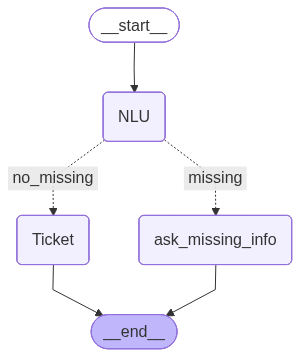

In [9]:
complaint_graph

In [12]:
response = complaint_graph.invoke({'user_input':"My Phone is broken."},config=config)
# response = complaint_graph.invoke({'user_input':"1st October 2024"},config=config)

In [13]:
print(response['messages'][-1].content)

Ticket YB626E75 has been created.


In [14]:
@tool
def churn_score(user_input:str)->int:
    """
        Calculate a churn risk score from user input.
        Returns category: high, medium, or low.
    """

    system_prompt = """ 
    You are a churn detection assistant.
    Based on the user input, classifiy their churn risk into:
    - high: user explicitly wants to cancel, switch, or sounds very frustrated.
    - medium: user shows dissatisfaction but hasn't decided to cancel yet.
    - low: user just asking questions or mild complaints.

    Examples:
    User: "I'm cancelling this useless service today."
    Churn risk: high

    User: "Your prices keep going up, I don't know if it's worth it anymore."
    Churn risk: medium

    User: "How do I cancel if I ever need to in the future?"
    Churn risk: low

    Respond with only one of: high, medium, low.
    """
    score = llm.invoke([
        {'role':'system', 'content':system_prompt},
        {'role':'user', 'content':user_input}
    ]).content

    return str(score)

@tool
def loyalty_score(score:str)->str:
    """ 
        Provide rewards to user based on churn score. 
    """
    reward_weights = {'high': 1.0, "medium": 0.6, "low": 0.2}
    clv_values = {"high": 1000, "medium": 500, "low": 200}
    clv_tier=random.choices(
        ['high','medium','low'],
        weights=[0.25,0.45,0.3],
        k=1
    )[0]

    loyalty_score = reward_weights[score]*clv_values[clv_tier]

    return loyalty_score, clv_tier

@tool
def loyalty_rewards(user_input:str, loyalty_score:float, churn_score:str)->str:
    """
    Generate a personalized retention message.
    """
    system_prompt=""" 
    You are a customer retention assistant. 
    Generate a polite, empathetic message based on the following:
    - The user's message
    - Their churn risk (high, medium, low)
    - Their loyalty score (40-1000)

    Rules:
    - If loyalty score >= 800 → emphasize strong appreciation and give a high reward (e.g., big discount, free premium month).
    - If 500-799 → show gratitude and offer a medium reward (e.g., discount or perk).
    - If 200-499 → acknowledge their value and give a small reward (e.g., loyalty points or small discount).
    - If < 200 → do not give a reward, just apologize and promise to improve.
    - If churn risk = high → always start by apologizing and showing empathy before mentioning any reward.
    - Keep the message short, friendly, concise and natural. Do not include technical terms or scores.
    
    Respond with only the final concise message.
    """

    user_context = f"""
        User message: {user_input}
        Churn risk: {churn_score}
        Loyalty score: {loyalty_score}
        """

    response = llm.invoke([{'role':'system', 'content':system_prompt},
                           {'role':'user','content':user_context}]).content
    
    return str(response)


In [15]:
def retention_node(state:SupervisorState)->SupervisorState:
    score = churn_score(state['user_input'])
    rewards = loyalty_score(score)
    loyalty=loyalty_rewards({'user_input':state['user_input'],'reward_score':rewards, 'churn_score':score})
    print(rewards)
    print(loyalty)
    return {'messages':[f"Retention Handled: {state['user_input']}"]}

In [18]:
graph = StateGraph(SupervisorState)
graph.add_node("Supervisor",supervisor_node)
graph.add_node("Inquiry Agent",inquiry_node)
graph.add_node("Complaint Agent",complaint_graph)
graph.add_node("Retention Agent",retention_node)
graph.add_node("Fallback", fallback) 

graph.add_edge(START, "Supervisor")

graph.add_edge("Supervisor", "Inquiry Agent")
graph.add_edge("Supervisor", "Complaint Agent")
graph.add_edge("Supervisor", "Retention Agent")
graph.add_edge("Supervisor", "Fallback")
graph.add_edge("Inquiry Agent", END)
graph.add_edge("Complaint Agent", END) 
graph.add_edge("Retention Agent", END)
graph.add_edge("Fallback", END)

app = graph.compile()

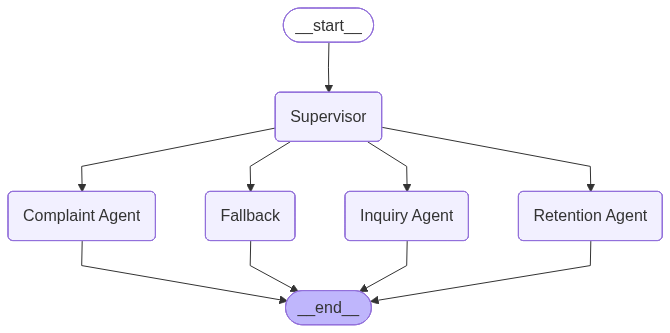

In [19]:
app